In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno
import warnings
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.base import clone
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
%matplotlib inline

In [12]:
import pandas as pd
df=pd.read_csv("train.csv")
# Filtre des variables catégorielles
df_catégorielles = df[['price_range', 'n_cores', 'blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']].astype(str)


# Calcule du nombre de valeurs uniques et les valeurs uniques pour chaque caractéristique
nombres_uniques = df_catégorielles.nunique()
valeurs_uniques = df_catégorielles.apply(lambda x: x.unique())

# Création d'un nouveau dataframe avec les résultats
pd.DataFrame({'Nombre de Valeurs Uniques': nombres_uniques, 'Valeurs Uniques': valeurs_uniques})
#Filtre des variables numériques
df_numerical = df.drop(df_catégorielles.columns, axis=1)

# Description statistique des variables numériques
df_numerical.describe()

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,pc,px_height,px_width,ram,sc_h,sc_w,talk_time
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,1.522250,4.309500,32.046500,0.501750,140.249000,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000
std,439.418206,0.816004,4.341444,18.145715,0.288416,35.399655,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955
min,501.000000,0.500000,0.000000,2.000000,0.100000,80.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000
25%,851.750000,0.700000,1.000000,16.000000,0.200000,109.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000
50%,1226.000000,1.500000,3.000000,32.000000,0.500000,141.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000
75%,1615.250000,2.200000,7.000000,48.000000,0.800000,170.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000
max,1998.000000,3.000000,19.000000,64.000000,1.000000,200.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000


In [13]:
# Create the subplots
fig = make_subplots(rows=3, cols=3, specs=[[{'type':'domain'}]*3]*3, vertical_spacing=0.05, horizontal_spacing=0.01)

# Loop through all the features and add the pie chart to the subplot
for i, feature in enumerate(df_catégorielles.columns):
    value_counts = df_catégorielles[feature].value_counts()
    labels = value_counts.index.tolist()
    values = value_counts.values.tolist()

    # Define color map based on orangered color
    cmap = colors.LinearSegmentedColormap.from_list("orangered", ["orangered", "white"])
    norm = colors.Normalize(vmin=0, vmax=len(labels))
    color_list = [colors.rgb2hex(cmap(norm(i))) for i in range(len(labels))]

    # Create the pie chart
    pie_chart = go.Pie(
        labels=labels,
        values=values,
        hole=0.6,
        marker=dict(colors=color_list, line=dict(color='white', width=3)),
        textposition='inside',
        textinfo='percent+label',
        title=feature,  # Add title with the feature name
        title_font=dict(size=25, color='black', family='Calibri')
    )

    # Add the pie chart to the subplot
    if i < 8:
        row = i // 3 + 1
        col = i % 3 + 1
        fig.add_trace(pie_chart, row=row, col=col)

# Update the layout
fig.update_layout(showlegend=False, height=1000, width=980, 
                   title={
                          'text':"Distribution of Categorical Variables",
                          'y':0.95,
                          'x':0.5,
                          'xanchor':'center',
                          'yanchor':'top',
                          'font': {'size':28, 'color':'black', 'family':'Calibri'}
                         })

# Show the plot
fig.show()

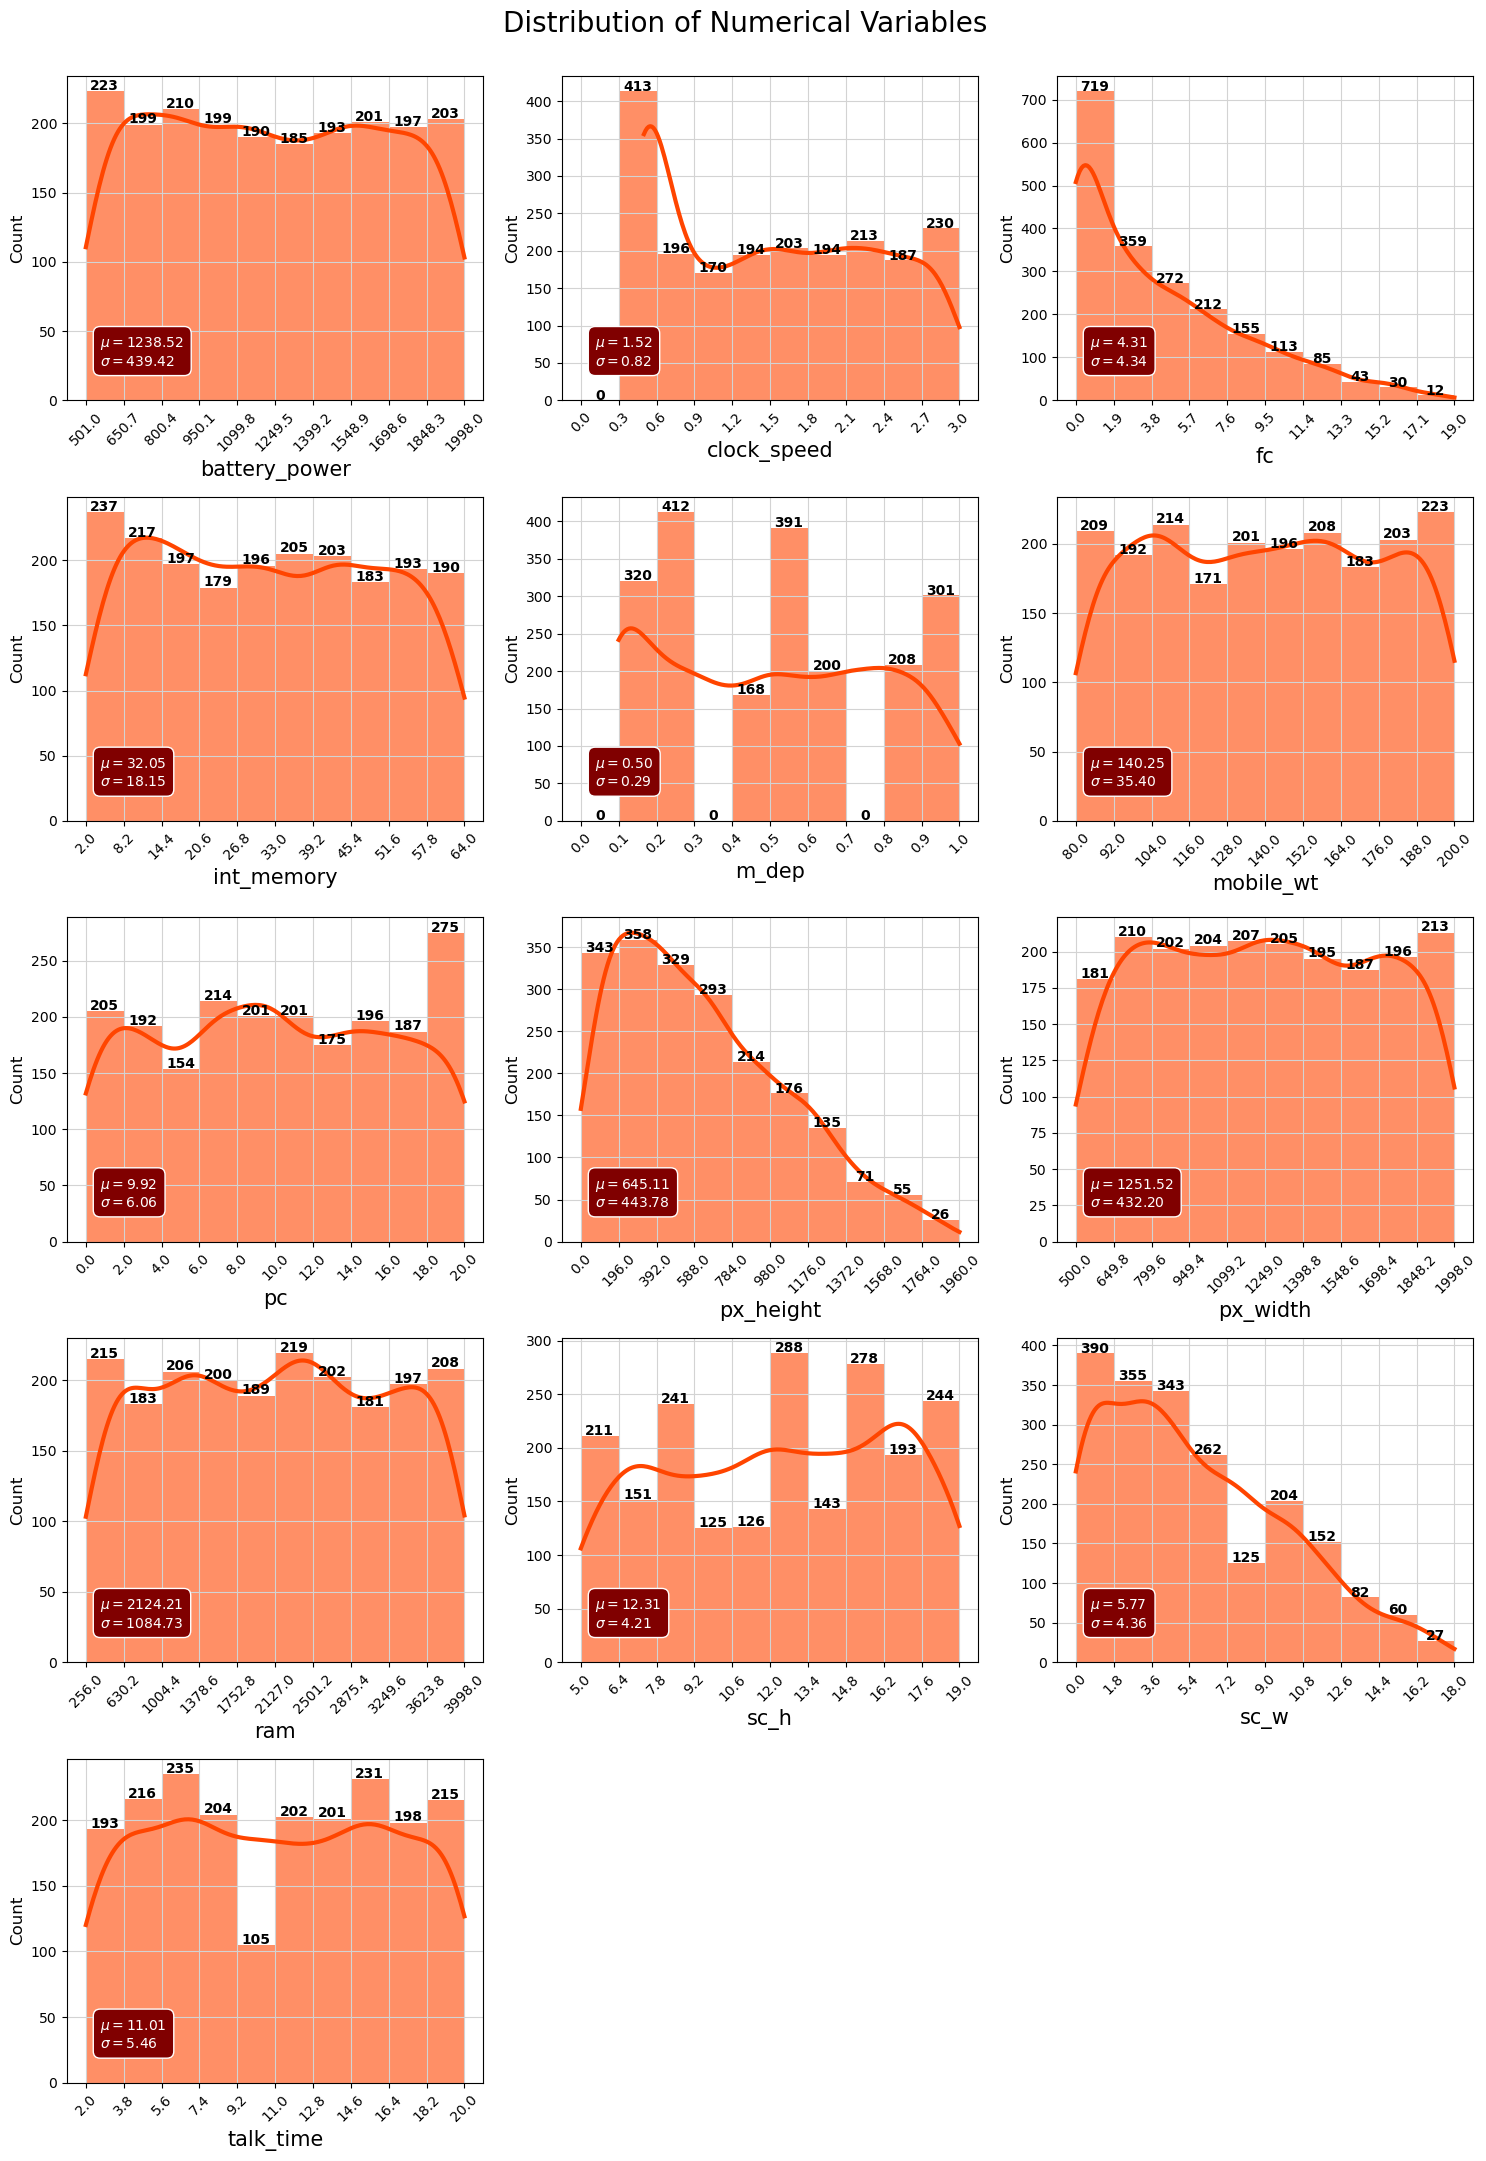

In [14]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15,22)) #, dpi=200
c = 'orangered'

for i, col in enumerate(df_numerical.columns):
    x = i//3
    y = i%3
    values, bin_edges = np.histogram(df_numerical[col], 
                                     range=(np.floor(df_numerical[col].min()), np.ceil(df_numerical[col].max())))                
    graph = sns.histplot(data=df_numerical, x=col, bins=bin_edges, kde=True, ax=ax[x,y],
                         edgecolor='none', color=c, alpha=0.6, line_kws={'lw': 3})
    ax[x,y].set_xlabel(col, fontsize=15)
    ax[x,y].set_ylabel('Count', fontsize=12)
    ax[x,y].set_xticks(np.round(bin_edges,1))
    ax[x,y].set_xticklabels(ax[x,y].get_xticks(), rotation = 45)
    ax[x,y].grid(color='lightgrey')
    for j,p in enumerate(graph.patches):
        ax[x,y].annotate('{}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+1),
                             ha='center', fontsize=10 ,fontweight="bold")
    textstr = '\n'.join((
    r'$\mu=%.2f$' %df_numerical[col].mean(),
    r'$\sigma=%.2f$' %df_numerical[col].std()
    ))
    ax[x,y].text(0.08, 0.2, textstr, transform=ax[x,y].transAxes, fontsize=10, verticalalignment='top',
                color='white', bbox=dict(boxstyle='round',facecolor='maroon', edgecolor='white', pad=0.5))
    
ax[4, 1].axis('off')
ax[4, 2].axis('off')
plt.suptitle('Distribution of Numerical Variables', fontsize=20) 
plt.tight_layout()   
plt.subplots_adjust(top=0.95)
plt.show()

<Axes: >

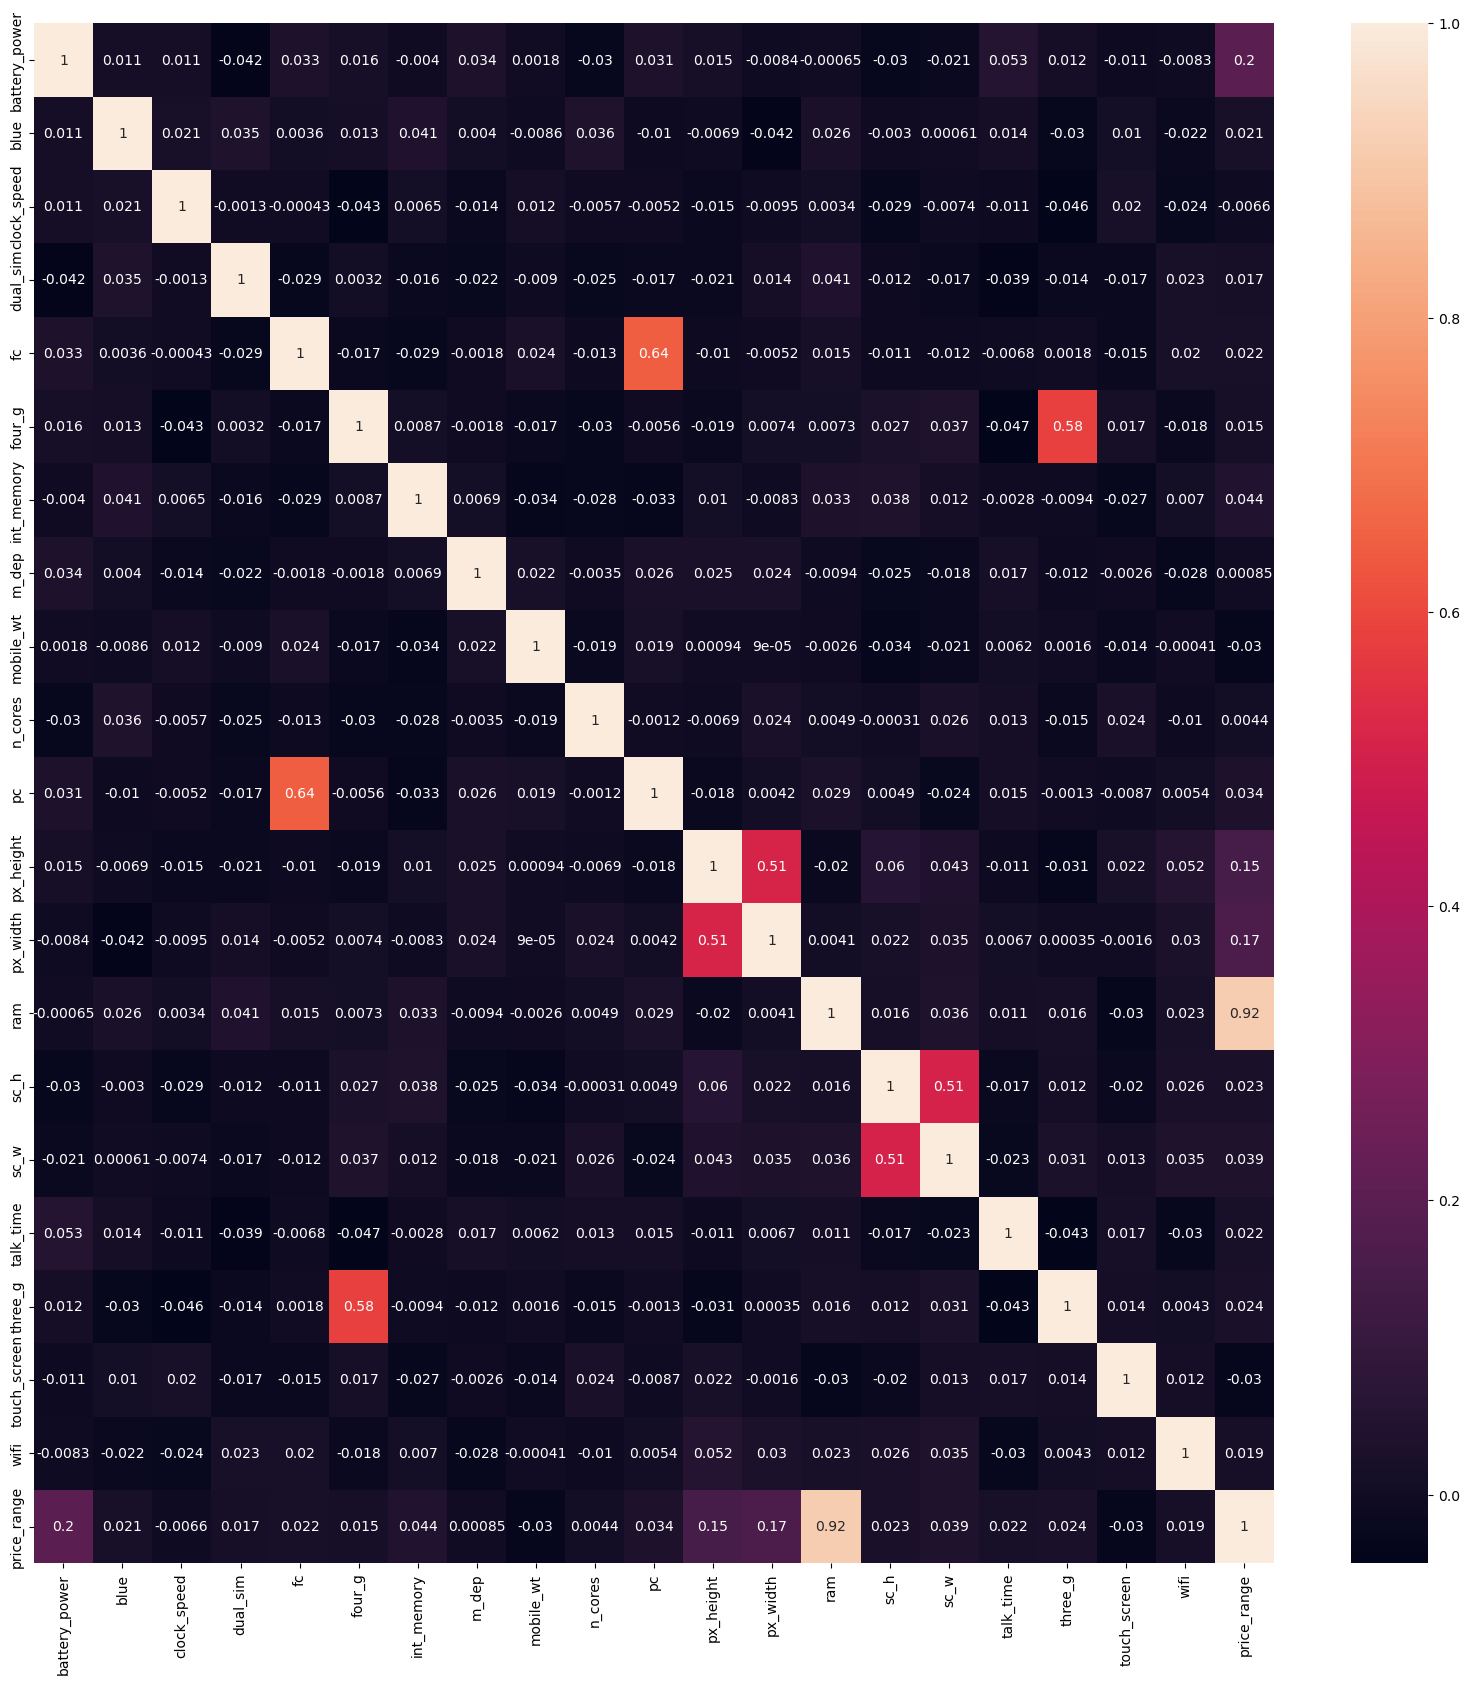

In [15]:

plt.figure(figsize=[20,20])
corr=df.corr()
sns.heatmap(corr,annot=True)


Text(0.5, 1.0, 'Classification du Price Range de chaque téléphone en fonction de la ram')

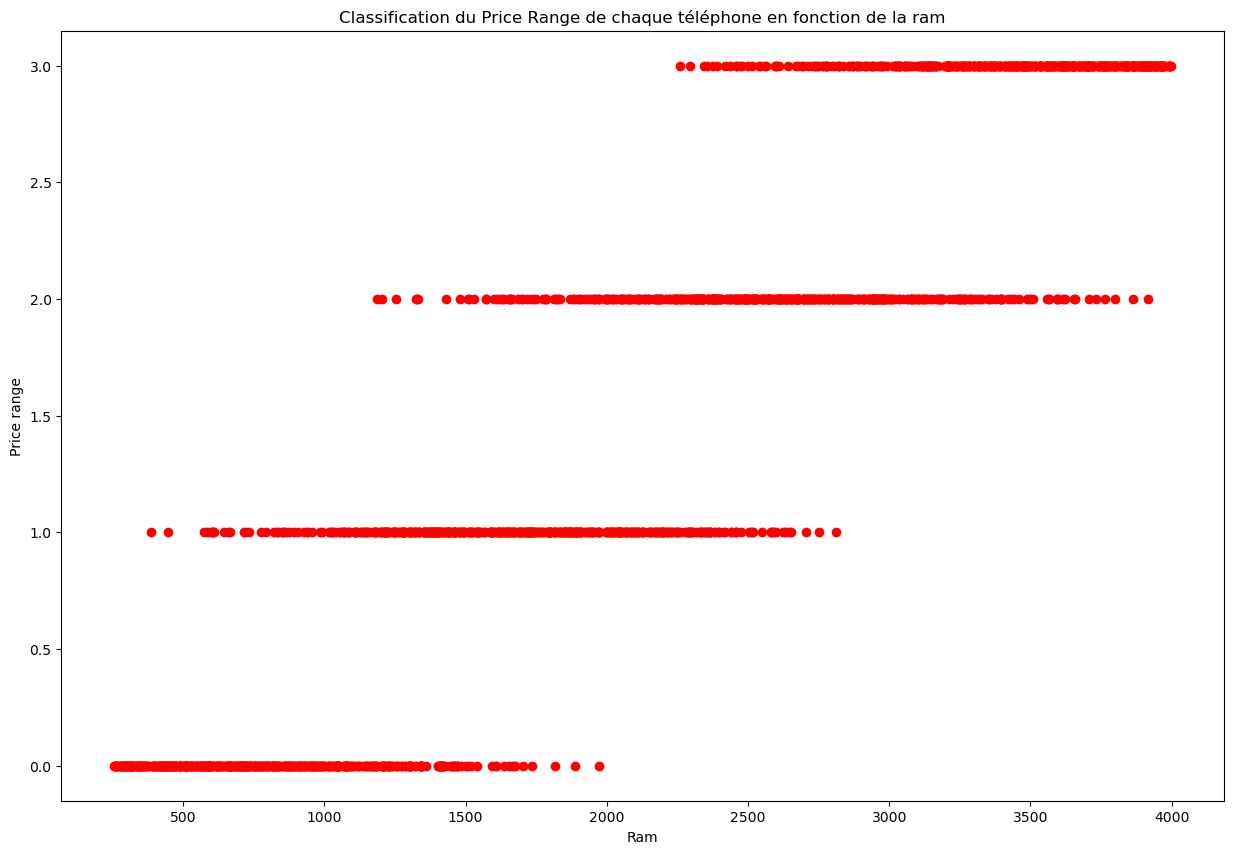

In [16]:
df_training1=df[["ram","price_range"]]
X1=df_training1['ram']
y1=df_training1['price_range']
plt.figure(figsize=[15,10])
plt.scatter(X1,y1,c='r')
plt.ylabel("Price range")
plt.xlabel('Ram')
plt.title("Classification du Price Range de chaque téléphone en fonction de la ram")


Text(0.5, 1.0, 'Classification du Price Range de chaque téléphone en fonction de la ram et de la capacité de batterie')

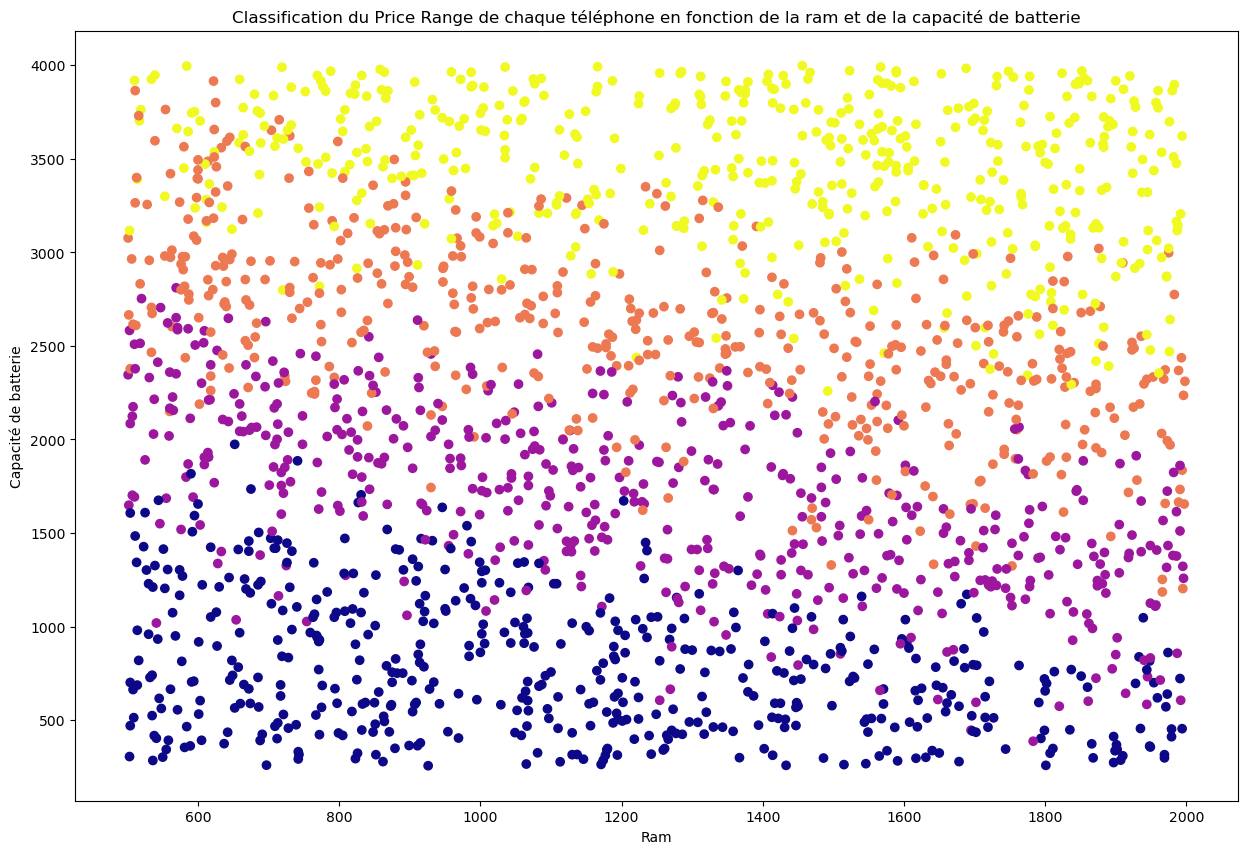

In [17]:
#Prix en fonction de la ram et de la capacité de batterie du téléphone.
df_training2=df[["ram","battery_power","price_range"]]

X2=np.array(df_training2["battery_power"])
y2=np.array(df_training2["ram"])
color=np.array(df_training2["price_range"])

plt.figure(figsize=[15,10])
plt.scatter(X2,y2,c=color,cmap="plasma")
plt.ylabel("Capacité de batterie")
plt.xlabel('Ram')
plt.title("Classification du Price Range de chaque téléphone en fonction de la ram et de la capacité de batterie")



Text(0.5, 1.0, 'Classification du Price Range de chaque téléphone en fonction de la ram et de la capacité de batterie')

<Figure size 2000x1300 with 0 Axes>

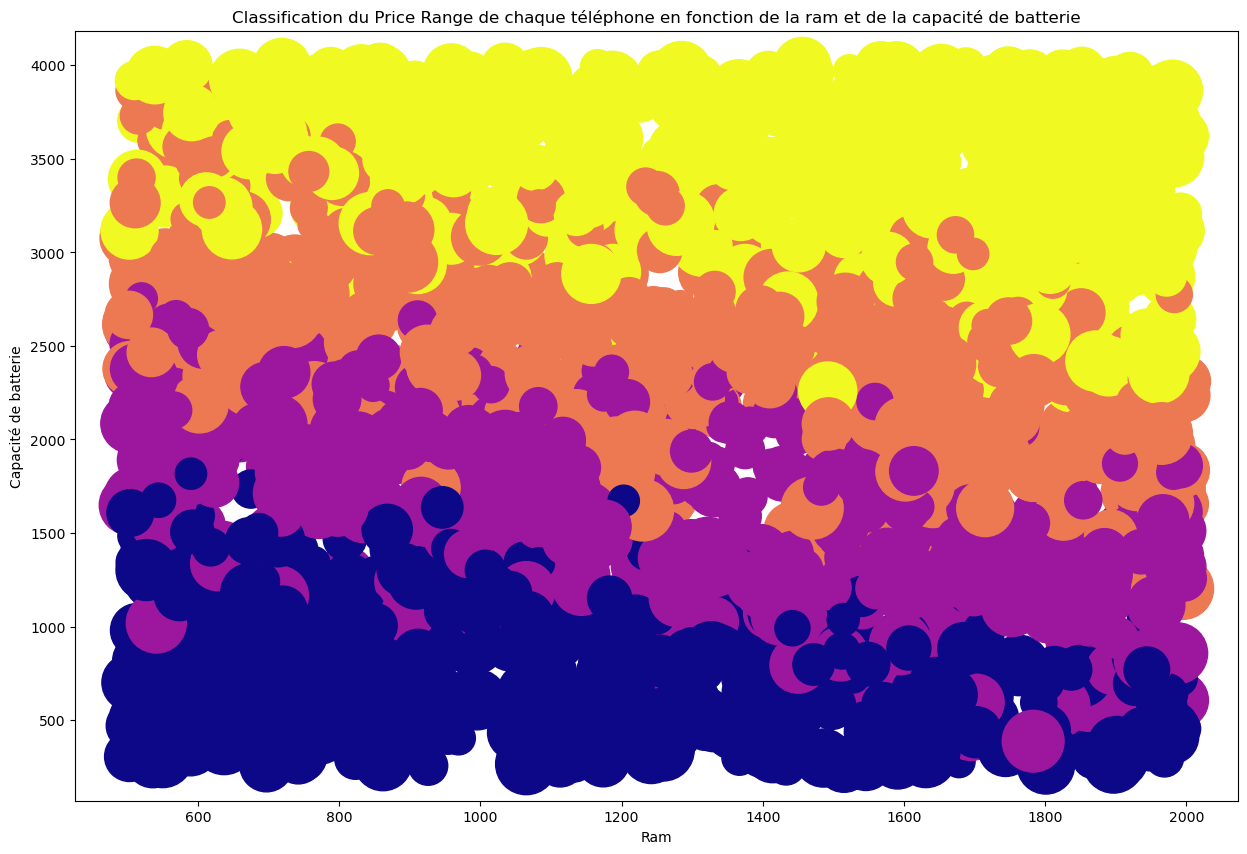

In [18]:
#Prix en fonction de la ram, de la largeur et de la capacité de batterie du téléphone.
plt.figure(figsize=[20,13])
df_training3=df[["ram","battery_power","px_width","price_range"]]

X3=np.array(df_training3["battery_power"])
y3=np.array(df_training3["ram"])
color=np.array(df_training3["price_range"])
size=np.array(df_training3["px_width"])

plt.figure(figsize=[15,10])
plt.scatter(X3,y3,c=color,s=size,cmap="plasma")
plt.ylabel("Capacité de batterie")
plt.xlabel('Ram')
plt.title("Classification du Price Range de chaque téléphone en fonction de la ram et de la capacité de batterie")

In [19]:
#knn avec ram et battery 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
nbvoisin=5 #Choix du nombre de voisin 

#Import du dataset de test  
datatest=pd.read_csv("test.csv")

#Reshape de X1 pour avoir une matrice à deux dimension , neccessaire pour knn
X1.array.reshape(-1,1)

X_train=df_training3[]
y_train=
X_test=
y_test=

#Normalisation des données
scaler=StandardScaler
Xtrain_norm=scaler.fit_transform(X_train)
y_train_norm=scaler.fit_transform(y_train)


#Entrainement du dataset
neigh1=KNeighborsClassifier(n_neighbors=nbvoisin,n_jobs=-1)
neigh1.fit(X,y1)
print(neigh1.predict([[1.1]]))
print(neigh1.predict_proba([[0.9]]))


SyntaxError: invalid syntax (3806612764.py, line 13)

In [ ]:
df_training3

,ram,price_range,battery_power,px_width
0,2549,1,842,756
1,2631,2,1021,1988
2,2603,2,563,1716
3,2769,2,615,1786
4,1411,1,1821,1212
...,...,...,...,...
1995,668,0,794,1890
1996,2032,2,1965,1965
1997,3057,3,1911,1632
1998,869,0,1512,670


In [ ]:
X

<PandasArray>
[
[2549],
[2631],
[2603],
[2769],
[1411],
[1067],
[3220],
[700],
[1099],
[513],
[3946],
[3826],
[1482],
[2680],
[373],
[568],
[3554],
[3752],
[1835],
[2337],
[2819],
[3283],
[1433],
[1037],
[2583],
[2782],
[3763],
[3286],
[2373],
[478],
[3532],
[508],
[2227],
[3845],
[1262],
[1326],
[2113],
[3429],
[3169],
[2150],
[2484],
[3339],
[1878],
[1629],
[504],
[1152],
[3587],
[2296],
[1270],
[3238],
[2059],
[2053],
[3112],
[1440],
[2908],
[2552],
[905],
[3963],
[2056],
[2910],
[1457],
[431],
[470],
[2148],
[2955],
[3366],
[3068],
[3834],
[1050],
[3993],
[3378],
[2192],
[392],
[3709],
[590],
[1814],
[907],
[1449],
[3448],
[1837],
[3464],
[2593],
[3484],
[2009],
[2048],
[837],
[854],
[3210],
[2746],
[2334],
[2822],
[1971],
[1410],
[349],
[1418],
[3616],
[880],
[1601],
[1412],
[1692],
[2600],
[1308],
[2413],
[1047],
[1204],
[1799],
[2676],
[2597],
[3029],
[2343],
[2016],
[2213],
[790],
[3182],
[3472],
[2871],
[3187],
[1945],
[488],
[1214],
[2598],
[3242],
[3534],
[3426],
[2488],
[32

In [ ]:
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)
print(neigh.predict([[1.1]]))
print(neigh.predict_proba([[0.9]]))

[0]
[[0.66666667 0.33333333]]
